In [11]:
from datetime import datetime
import pandas as pd
from geopy.distance import distance
import numpy as np
import json

import pymongo
from pymongo import MongoClient



from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import statsmodels.api as sm




import pymongo
from pymongo import MongoClient

import matplotlib.pyplot as plt

plt.style.use("ggplot")

%matplotlib inline

In [5]:
# Load in our parameters file
with open('../parameters.json') as f:
    params = json.load(f)

# Get relevant parameters
database = params['database']
# labeled_collection = params['labeled_collection']
# chunk_collection = params['chunk_collection']
# duration_collection = params['duration_collection']
two_chunk_collection = params['two_chunk_collection']
# six_chunk_collection = params['six_chunk_collection']

# Connect to our database/collection
client = MongoClient('localhost', 27017)
db = client[database]
# trip_coll = db[labeled_collection]
# chunk_coll = db[chunk_collection]
# duration_coll = db[duration_collection]
two_chunk_coll = db[two_chunk_collection]
# six_chunk_coll = db[six_chunk_collection]

In [7]:
chunk_df = pd.DataFrame(list(two_chunk_coll.find({},{'_id':0})))

chunk_df.head()

,avg_speed_chnk_1,avg_speed_chnk_2,chnk1_mfn_sq_chnk_1,chnk1_mfn_sq_chnk_2,seconds_chnk_1,seconds_chnk_2
0,5.563081,5.117909,481636,452929,1250.0,1027.0
1,5.051780,5.112077,12321,7396,1438.0,1428.0
2,4.878015,3.558431,729,2916,1560.0,1806.0
3,4.676721,3.959559,28900,39204,1682.0,1550.0
4,4.587672,3.931596,96100,114244,1678.0,1534.0


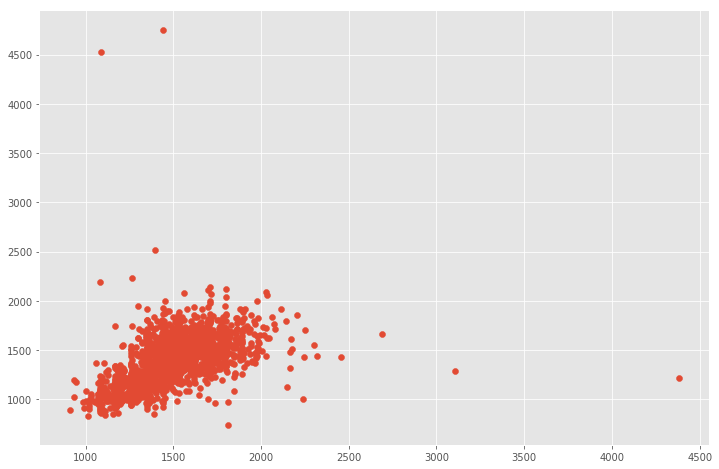

In [15]:
x = chunk_df['seconds_chnk_1'].values
y = chunk_df['seconds_chnk_2'].values
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x, y);

In [16]:
mask = (chunk_df['seconds_chnk_1'] < 2500) & (chunk_df['seconds_chnk_2'] < 2500)
trimed_chnk_df = chunk_df[mask]

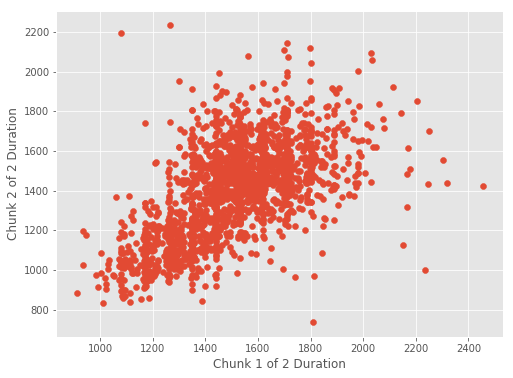

In [28]:
x = trimed_chnk_df['seconds_chnk_1'].values
y = trimed_chnk_df['seconds_chnk_2'].values
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y)
ax.set_xlabel("Chunk 1 of 2 Duration")
ax.set_ylabel("Chunk 2 of 2 Duration")
plt.savefig('chunk_2_prior.jpg');

In [18]:
y = trimed_chnk_df['seconds_chnk_2'].values
y = y.reshape(-1,1)

X = trimed_chnk_df[['seconds_chnk_1', 'chnk1_mfn_sq_chnk_1']].values

In [19]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# Build our model
ridge_cv = RidgeCV(alphas=[5,10,20,30], cv=20)
ridge_cv.fit(X_train, y_train)

#Score our model, R-Squared
r_squared = ridge_cv.score(X_test, y_test)

#Score our model, Root Mean Squared Error
y_predict = ridge_cv.predict(X_test)
rmse_norm = (mean_squared_error(y_test, y_predict))**.5
rmse_dev = scaler_y.inverse_transform([rmse_norm])
diff = rmse_dev[0] - scaler_y.mean_[0]

print ("R-squared: ", "{0:.2f}".format(r_squared))
print ('RMSE: ', "{0:.2f}".format(diff))

R-squared:  0.46
RMSE:  167.70


In [21]:
# 2:45 error on a 23:30 section
trimed_chnk_df['seconds_chnk_2'].mean()

1404.8319327731092

In [22]:
# fit with statsmodels
model1 = sm.OLS(y_train,X_train)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     746.7
Date:                Tue, 08 May 2018   Prob (F-statistic):          1.36e-222
Time:                        09:18:20   Log-Likelihood:                -1519.9
No. Observations:                1428   AIC:                             3044.
Df Residuals:                    1426   BIC:                             3054.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3855      0.021     18.010      0.000       0.344       0.428
x2            -0.4370      0.021    -20.919      0.000      -0.478      -0.396
==============================================================================
Omnibus:                      138.411   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.919
Skew:                           0.541   Prob(JB):                     3.82e-77
Kurtosis:                       5.178   Cond. No.                         1.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
5/50

0.1

In [31]:
3/25

0.12

In [32]:
1/8

0.125

In [34]:
df = pd.read_csv('../data/gtfs/sfmta_2017-02-10/stop_times.txt')

In [35]:
df.head()

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,7225088,26:00:00,26:00:00,4015,1,,,,
1,7225088,26:00:45,26:00:45,6294,2,,,,
2,7225088,26:01:35,26:01:35,6290,3,,,,
3,7225088,26:02:00,26:02:00,6314,4,,,,
4,7225088,26:02:35,26:02:35,6307,5,,,,


In [39]:
df_sort = df.sort_values('departure_time', ascending=False)


In [44]:
trip_sort = df_sort[df_sort['trip_id'] == 7272703].sort_values('departure_time')
trip_sort

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
812874,7272703,29:05:00,29:05:00,390,1,,,,
812875,7272703,29:06:18,29:06:18,3402,2,,,,
812876,7272703,29:07:06,29:07:06,3355,3,,,,
812877,7272703,29:07:20,29:07:20,3378,4,,,,
812878,7272703,29:07:53,29:07:53,3391,5,,,,
812879,7272703,29:08:26,29:08:26,3401,6,,,,
812880,7272703,29:08:49,29:08:49,3398,7,,,,
812881,7272703,29:09:18,29:09:18,3396,8,,,,
812882,7272703,29:09:41,29:09:41,3394,9,,,,
812883,7272703,29:10:05,29:10:05,3392,10,,,,


In [139]:
two_cnk_info = chnk_coll.find_one({'number_chunks':2})

In [140]:
all_trips = trip_coll.distinct('trip_id_iso')
# # Testing
# all_trips = all_trips[33:34]

In [141]:
trip_list = []

for trip in all_trips:
    
    trip_data = {}
    
    breakin = 0
    
    for chnk_seq, chnk_data in two_cnk_info['chunks'].items():
        
        search = {
            'trip_id_iso': trip,
            'chunk_2': chnk_seq
        }
        
        chnk_str = '_chnk_' + chnk_seq
        
        chnk_cursor = trip_coll.find(search)
        
        chnk_df = pd.DataFrame(list(chnk_cursor))
        
        min_ts = chnk_df['time_stamp'].min()
        max_ts = chnk_df['time_stamp'].max()
        chnk_secs = max_ts - min_ts
        
        if chnk_secs > 3000:
            breakin += 1
            break
        
        trip_data['seconds' + chnk_str ] = chnk_secs
        
        min_dt = datetime.fromtimestamp(min_ts)
        mfn_sq = (((min_dt.hour * 60) + min_dt.minute) - 720)**2
        
        mfn_abs = abs(((min_dt.hour * 60) + min_dt.minute) - 720)
        
        trip_data['chnk1_mfn_sq' + chnk_str] = mfn_sq
        trip_data['chnk1_mfn_abs' + chnk_str] = mfn_abs
        
        
        avg_spd = chnk_df['SPEED'].astype('float').mean()
        
        trip_data['avg_speed' + chnk_str] = avg_spd
        
    if breakin == 0:
        
        trip_list.append(trip_data)

In [142]:
chnky_df = pd.DataFrame(trip_list)

In [170]:
chnky_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 8 columns):
avg_speed_chnk_1        1320 non-null float64
avg_speed_chnk_2        1320 non-null float64
chnk1_mfn_abs_chnk_1    1320 non-null int64
chnk1_mfn_abs_chnk_2    1320 non-null int64
chnk1_mfn_sq_chnk_1     1320 non-null int64
chnk1_mfn_sq_chnk_2     1320 non-null int64
seconds_chnk_1          1320 non-null float64
seconds_chnk_2          1320 non-null float64
dtypes: float64(4), int64(4)
memory usage: 82.6 KB


In [160]:
y = chnky_df['seconds_chnk_2'].values
y = y.reshape(-1,1)

In [161]:
# X = chnky_df[['chnk1_mfn_abs_chnk_1', 'seconds_chnk_1']].values

X = chnky_df[['seconds_chnk_1']].values
X = X.reshape(-1,1)

# X = chnky_df[['chnk1_mfn_sq_chnk_1', 'avg_speed_chnk_1']].values

In [162]:
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)

scaler_y = StandardScaler()
y_norm = scaler_y.fit_transform(y)

# X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

# X_norm = X
# y_norm = y

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_norm)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.357
Method:                 Least Squares   F-statistic:                     549.7
Date:                Fri, 04 May 2018   Prob (F-statistic):           5.06e-97
Time:                        15:12:53   Log-Likelihood:                -1176.9
No. Observations:                 990   AIC:                             2356.
Df Residuals:                     989   BIC:                             2361.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5951      0.025     23.446      0.000       0.545       0.645
==============================================================================
Omnibus:                       94.976   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              568.688
Skew:                          -0.160   Prob(JB):                    3.24e-124
Kurtosis:                       6.699   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [166]:
regr = RandomForestRegressor(n_estimators=50, max_depth=1)

crossed = cross_validate(regr, X_norm, y_norm.flatten(), cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -0.6510656261520446
RMSE:  1617.8485856101697


In [169]:
ols = LinearRegression(fit_intercept=False)

ols_crossed = cross_validate(ols, X_norm, y_norm, cv=20, 
                         scoring=['neg_mean_squared_error','r2'], return_train_score=False)

rmse_norm = (abs(ols_crossed['test_neg_mean_squared_error'].mean()))**.5
r2 = ols_crossed['test_neg_mean_squared_error'].mean()

print ("R-squared: ", r2)
print ('RMSE: ', scaler_y.inverse_transform([rmse_norm])[0])

R-squared:  -0.6543444545736409
RMSE:  1618.4586989268755


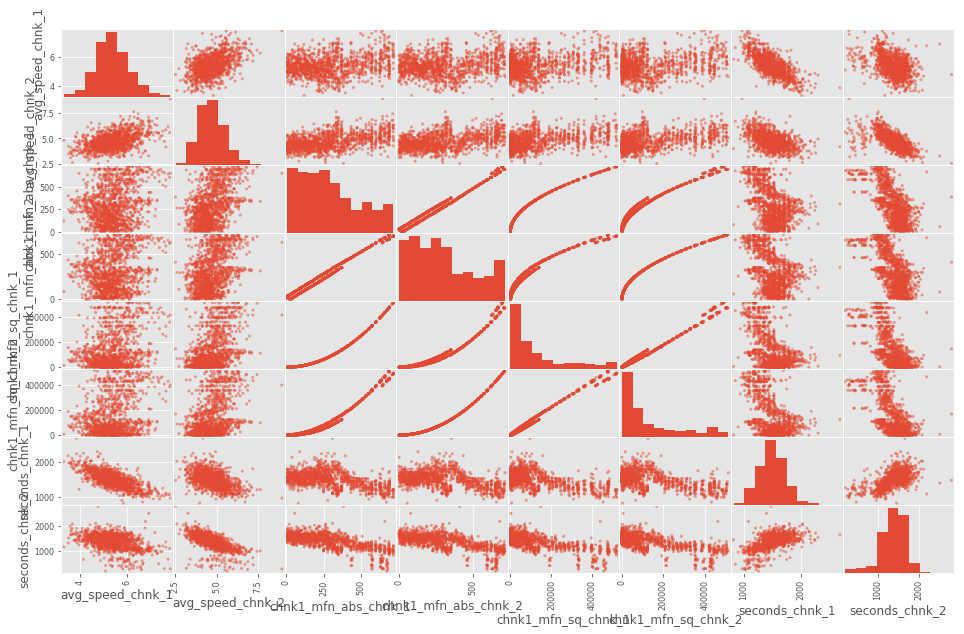

In [150]:
pd.plotting.scatter_matrix(chnky_df, figsize=(16,10));

In [157]:
test_y = chnky_df['seconds_chnk_2'].values
test_x = chnky_df['seconds_chnk_1'].values

NameError: name 'test_x' is not defined

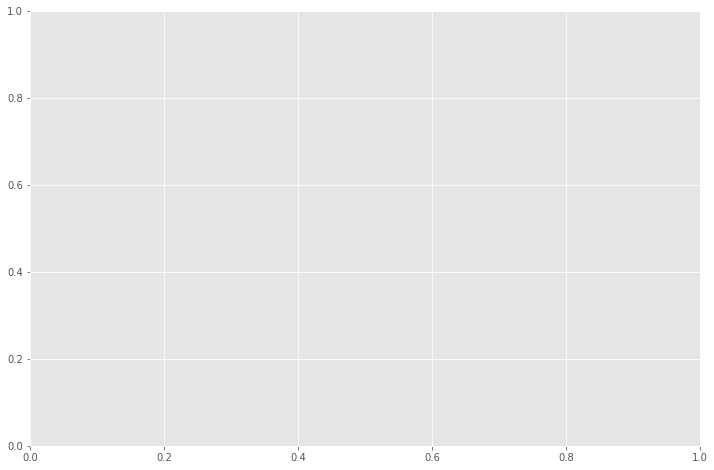

In [23]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(test_x, test_y);